# Warning
This notebook is under development- please use to evaluate entropy notebook and siggest desired changes only

# Experiments on information loss 

## Import libraries

In [1]:
%matplotlib widget
import ipywidgets as widgets
import matplotlib.pyplot as plt
import numpy as np
import sys
import os
import glob
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
# IMPORT Ole's fixed TMSiSDK python interfacwe- may change
sys.path.insert(0,'C:/Projects/tmsi-python-interface')
from TMSiSDK.file_readers import Poly5Reader
import collections
import math
sys.path.insert(0, '../rsemg')
import helper_functions as hf

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:321: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(scipy.__version__) >= '1.1':
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):
C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\mne\fixes.py:1134: DeprecationWarning: distutils Version classes are deprecated. Use packaging.version instead.
  if LooseVersion(numba.__version__) < LooseVersion('0.40'):


# Set a collection place for experiments

In [2]:
# do not rerun this cell
big_data_list= []

Below change the path to the root directory where you are keeping your EMGs and ventilator "Draeger" files

# Reruns should be done from this cell as the start

In [3]:
root_emg_directory = os.path.join('../not_pushed','topspin_data_anonymized')

In [4]:
emg_pattern = os.path.join(root_emg_directory, '**/*.Poly5')
emg_and_draeger_files = glob.glob(emg_pattern, recursive=True)

emg_files = []
draeger_files = []

for file in emg_and_draeger_files:
    if 'Draeger' in file:
        draeger_files.append(file)
    else:
        emg_files.append(file)

Now you can pick a file from the list, which have been numbered.

In [5]:
list_of_numbers_strung = []
for i in range(len(emg_files)):
    list_of_numbers_strung.append(str(i))


btn = widgets.Dropdown(
    options=list_of_numbers_strung,
    value='0',
    description='Picked File:',
    disabled=False,
)
display(btn)

Dropdown(description='Picked File:', options=('0', '1', '2', '3', '4', '5', '6', '7', '8', '9', '10', '11', '1…

In [6]:
number_chosen = int(btn.value)
file_chosen = emg_files[number_chosen] 
print("The file you chose is:",file_chosen)

The file you chose is: ../not_pushed\topspin_data_anonymized\M001\001\EMG_recording.Poly5


In [7]:
data_emg = Poly5Reader(file_chosen)
data_samples= data_emg.samples
emg_sample_rate = data_emg.sample_rate
converted_to_seconds =  []
for i in range(len(data_samples[0])):
    converted_to_seconds.append(i/emg_sample_rate)

Reading file  ../not_pushed\topspin_data_anonymized\M001\001\EMG_recording.Poly5
	 Number of samples:  172576 
	 Number of channels:  3 
	 Sample rate: 2048 Hz
Done reading data.


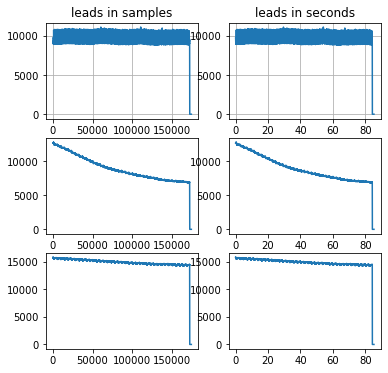

In [8]:
%matplotlib inline
# set up plotn
x = data_samples
fig, axis = plt.subplots(nrows = 3, ncols = 2, figsize=(6, 6))
#ax.set_ylim([-4, 4])
axis[0,0].grid(True)
axis[0,0].plot(x[0])
axis[0,0].set(title='leads in samples')
axis[1,0].plot(x[1])
axis[2,0].plot(x[2])
axis[0,1].set(title='leads in seconds')
axis[0,1].grid(True)
axis[0,1].plot(converted_to_seconds,x[0])
axis[1,1].plot(converted_to_seconds,x[1])
axis[2,1].plot(converted_to_seconds,x[2])

That is the whole unfiltered EMG, but you probably want to examine a part. You will also want to examine something filtered down to only the EMG components. Therefore we will filter off only the EMG components with an ICA in addtion to the filter we will play with.

Now you can filter down to which part you want to see. 

Do you want to cut and see the file in samples or seconds?

In [9]:
y_axis = widgets.Dropdown(
    options=["Samples","Seconds"],
    value='Samples',
    description="Select View Option",
    disabled=False,
)
display(y_axis)


Dropdown(description='Select View Option', options=('Samples', 'Seconds'), value='Samples')

In [20]:
time_view= y_axis.value
time_view

'Seconds'

In [21]:
# type in start number and press return for it to update
start = input()

0


In [22]:
# type in end number and press return for it to update
end= input()

10


In [23]:
start_s = float(start)* emg_sample_rate
end_s = float(end)*emg_sample_rate

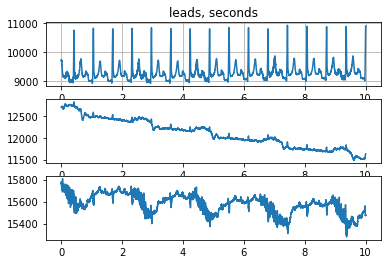

In [24]:
if time_view == 'Samples':
    # nox examine at a certain scale- from point a to b as samples
    x = data_samples
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(x[0][int(start):int(end)])
    ax_1.set(title='leads, samples')
    ax_2.plot(x[1][int(start):int(end)])
    ax_3.plot(x[2][int(start):int(end)])
    
if time_view == 'Seconds':
    # nox examine at a certain scale- from point a to b as samples
    x_for_secs = data_samples
    
    converter_for_sample_number =90
    
    y = converted_to_seconds
    fig, (ax_1,ax_2,ax_3) = plt.subplots(nrows = 3, figsize=(6, 4))
    ax_1.grid(True)
    ax_1.plot(y[int(start_s):int(end_s)],x[0][int(start_s):int(end_s)])
    ax_1.set(title='leads, seconds')
    ax_2.plot(y[int(start_s):int(end_s)],x[1][int(start_s):int(end_s)])
    ax_3.plot(y[int(start_s):int(end_s)],x[2][int(start_s):int(end_s)])
    

    

Happy with your selection? If not redo, then we can see how the filter the selection in a basic pipleline before extracint entropy.

In [25]:
def working_pipeline_pre_entropy(our_chosen_samples): 
    cut_file_data = hf.bad_end_cutter_for_samples(our_chosen_samples, percent_to_cut=3, tolerance_percent=5)
    bd_filtered_file_data = hf.emg_bandpass_butter_sample(cut_file_data, 5, 450, 2048, output='sos')
    # step 3 end-cutting again to get rid of filtering artifacts
    re_cut_file_data = hf.bad_end_cutter_for_samples(bd_filtered_file_data, percent_to_cut=3, tolerance_percent=5)
    # skip step4 and do step 5 ICA
    components = hf.compute_ICA_two_comp(re_cut_file_data)
    #     the picking step!
    emg= hf.pick_more_peaks_array(components)
    # now process it in final steps
    abs_values = abs(emg)
    final_envelope_d = hf.emg_highpass_butter(abs_values, 150, 2048)
    
        
    return final_envelope_d

C:\Users\makeda\anaconda3\envs\remgenv-4\lib\site-packages\sklearn\decomposition\_fastica.py:488: FutureWarning: From version 1.3 whiten='unit-variance' will be used by default.
  warnings.warn(


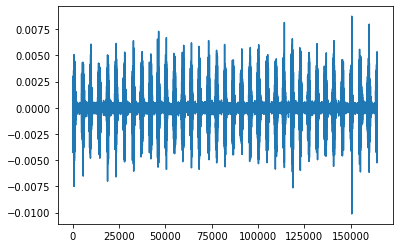

In [26]:
processed_data_emg = working_pipeline_pre_entropy(data_samples)
plt.plot(processed_data_emg)

Now we created some basic processed EMG. We will graph it based on te sample selected and the cutoff on entropy.

TODO: add seconds option here

In [27]:
# Now we want to select where the cut_off is

entropy_cutoff = widgets.Dropdown(
    options=["Mean","Half_range"],
    value='Mean',
    description="Select Entropy Cut off",
    disabled=False,
)
display(entropy_cutoff)


Dropdown(description='Select Entropy Cut off', options=('Mean', 'Half_range'), value='Mean')

20281
20480


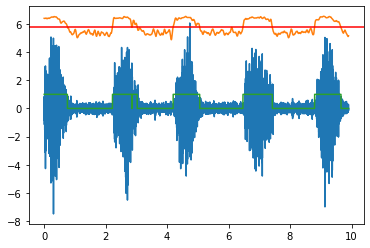

In [29]:
def rounded_for_ent(stralist):
    rounded= np.round_(stralist, decimals = 5)
    return rounded
if time_view == 'Samples':
    big_list = rounded_for_ent(processed_data_emg[int(start):int(end)])# replace with whole array of time series!
else:
    big_list = rounded_for_ent(processed_data_emg[int(start_s):int(end_s)])
slice_length = 100
def sliceIterator(lst, sliceLen):
    for i in range(len(lst) - sliceLen + 1):
        yield lst[i:i + sliceLen]
index_hold = []
for slice in sliceIterator(big_list, slice_length):
    entropy_index = hf.entropical(slice)
    index_hold.append(entropy_index)

if entropy_cutoff.value == 'Half_range':
    decision_cutoff = (np.max(index_hold) + np.min(index_hold))/2

else:# entropy_cutoff.value == 'Mean':
    decision_cutoff = np.mean(index_hold)


rms_rolled = hf.vect_naive_rolling_rms(index_hold,100)
if time_view == 'Samples':
    plt.plot(processed_data_emg[int(start):int(end)]*1000)
    plt.plot(rms_rolled)
    plt.plot(hf.zero_one_for_jumps_base(rms_rolled,decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    
else:
    y = converted_to_seconds
    plt.plot(y[int(start_s):int(len(rms_rolled))], processed_data_emg[int(start_s):len(rms_rolled)]*1000)
    plt.plot(y[int(start_s):int(len(rms_rolled))],rms_rolled[int(start_s):int(len(rms_rolled))])
    plt.plot(y[int(start_s):int(len(rms_rolled))],hf.zero_one_for_jumps_base(rms_rolled[int(start_s):int(len(rms_rolled))],decision_cutoff))
    plt.axhline(y = decision_cutoff, color = 'r', linestyle = '-')
    

Now we need to do this adaptively over the whole signal. But how often should we cut to get the mean or half value?

In [19]:
#You probably want to change the name to a timestamp, and save every hour, at least. 